Stage 1: Loading and aligning data...
   Files loaded successfully!
   ...data loaded and aligned successfully.
Stage 2: Patching SPX data holes...
     ... running SPX patch file creator 
     ... patch file './data/spx_patch.parquet' already exists. Skipping creation.
     ... successfully applied patch from './data/spx_patch.parquet'.
   ...done.
Stage 3: Identifying rebalancing dates...
   Found 540 rebalancing dates from 1980-01-31 to 2024-12-31.
Stage 4: Differentiating column types...
   Identified 131 stock columns and 7 factor columns.
Stage 5: Generating data overview dashboard...


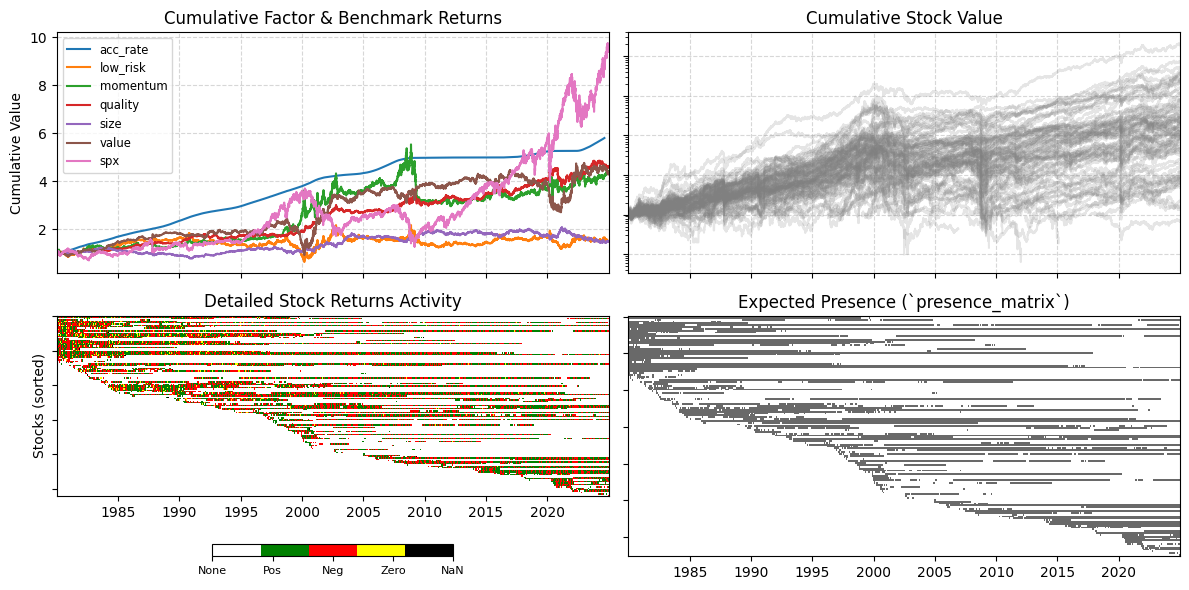

   ...dashboard generated.
Stage 6: Pre-calculating prices and volatility proxies...
   ...done.
Stage 7: Running the daily backtest loop...


100%|██████████| 11345/11345 [00:24<00:00, 472.05it/s]


   ...backtest complete. Portfolio weights generated.
Stage 7.1: Visualizing portfolio leverage and underlying volatilities...


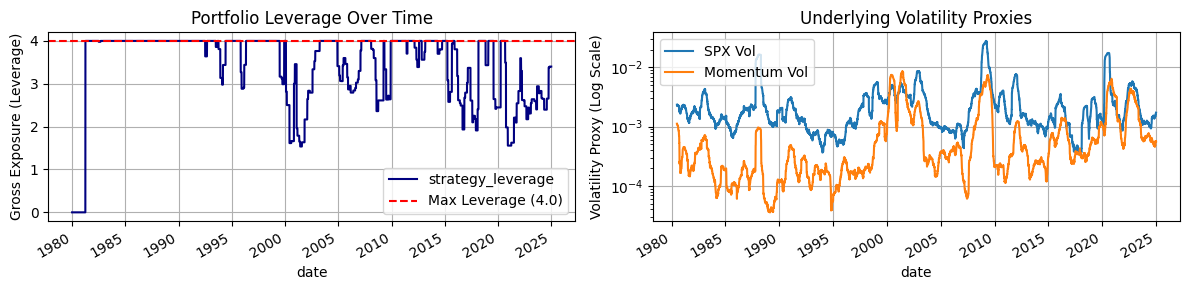

   ...done.
Stage 8: Calculating final performance metrics...
   ...metrics calculated.
Stage 9: Generating final performance report...


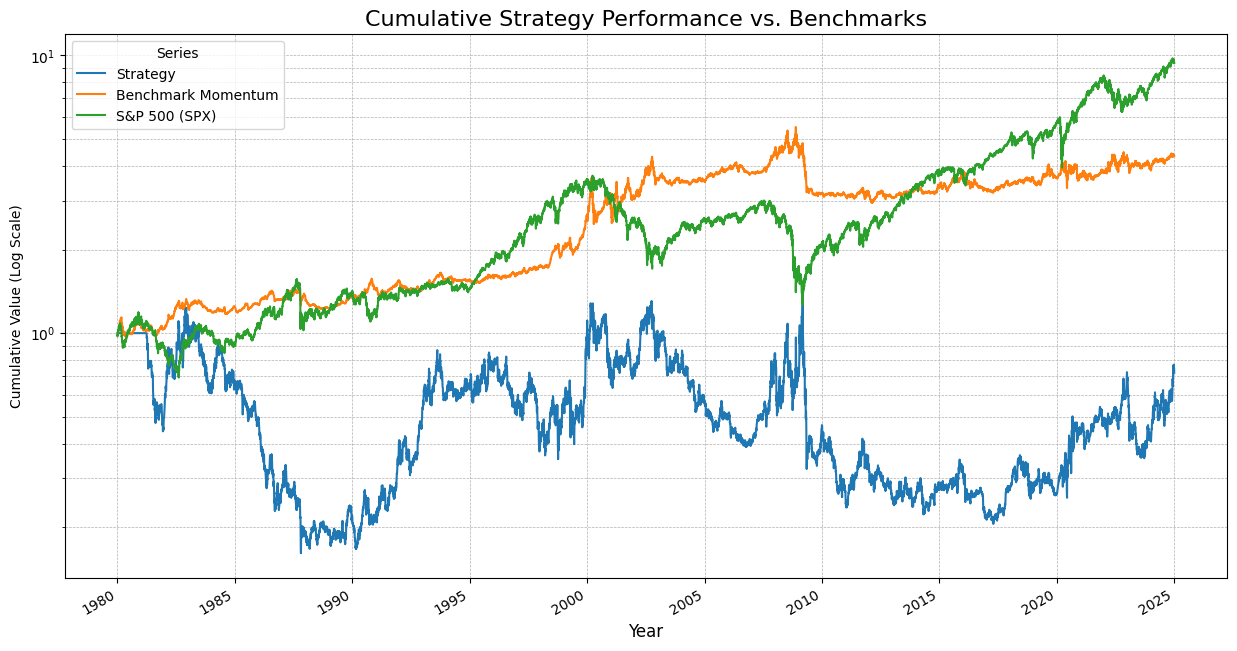


--- Summary Performance Metrics ---
                         Metric  Value
              Annualized Return -0.73%
          Annualized Volatility 36.20%
        Annualized Sharpe Ratio  -0.13
Annualized Alpha (vs 6 factors) -1.11%
              Information Ratio  -0.04
   ...report generated. Task complete.


In [ ]:
import pandas as pd
from helpers.plotting_utils import plot_dashboard, plot_leverage_and_volatility
from helpers.data_utils import create_spx_patch_file, data_loader, apply_spx_hole_patch
from helpers.strategy_logic import get_base_weights, get_risk_scale
from helpers.reporting_utils import calculate_performance_metrics, plot_performance_summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# --- Configuration ---
returns_file_path = './data/returns_df.parquet'
presence_file_path = './data/presence_matrix.parquet'

percentile_leg = 0.2

# SPX data was found to have missing values (holes)! This file stores the patch data. It uses yfinance lib, if the file is not found.
patch_filename = './data/spx_patch.parquet' 

non_stock_columns = [
    'acc_rate', 'low_risk', 'momentum', 
    'quality', 'size', 'value', 'spx'
]
figsize = (12, 6)

# --- Stage 1: Load Data ---
print("Stage 1: Loading and aligning data...")
data = data_loader(
    returns_file_path=returns_file_path, 
    presence_file_path=presence_file_path,
    non_stock_columns=non_stock_columns
)

if not data:
    # Handle error, maybe by raising an exception or exiting
    raise SystemExit("Data loading failed. Halting execution.")
else:
    returns_df = data['returns_df']
    presence_matrix = data['presence_matrix'] # The key is already aligned
    assert returns_df.index.equals(presence_matrix.index), "Indices of returns_df and presence_matrix do not match!"
    print("   ...data loaded and aligned successfully.")

# --- Stage 2: Patch SPX Data ---
print("Stage 2: Patching SPX data holes...")
create_spx_patch_file(returns_df, patch_filename=patch_filename, force_creation=False)
apply_spx_hole_patch(patch_filename, returns_df)
print("   ...done.")

# --- Stage 3: Identify Rebalancing Dates ---
print("Stage 3: Identifying rebalancing dates...")
rebal_dates = set(returns_df.index.to_series().resample('ME').last())
# Corrected max() instead of min() for the end of the range
print(f"   Found {len(rebal_dates)} rebalancing dates from {min(rebal_dates).date()} to {max(rebal_dates).date()}.")

# --- Stage 4: Identify Column Types ---
print("Stage 4: Differentiating column types...")
stock_columns = list(set(returns_df.columns) - set(non_stock_columns))
print(f"   Identified {len(stock_columns)} stock columns and {len(non_stock_columns)} factor columns.")


# --- Stage 5: Initial Data Visualization ---
print("Stage 5: Generating data overview dashboard...")
plot_dashboard(
    returns_df=returns_df,
    presence_matrix=presence_matrix,
    non_stock_columns=non_stock_columns,
    stock_columns=stock_columns,
    figsize=figsize
)
print("   ...dashboard generated.")

# --- Stage 6: Pre-calculate Data for Backtest ---
print("Stage 6: Pre-calculating prices and volatility proxies...")
prices_df = (1 + returns_df[stock_columns].fillna(0)).cumprod()

# Calculate the volatility proxy for risk control.
# The formula is: 21 * (sum of last 126 days of squared returns) / 126.
# A 1-day lag is required, so we use .shift(1).
returns_for_vol = returns_df[['spx', 'momentum']]
squared_returns = returns_for_vol**2
rolling_sum_sq = squared_returns.rolling(window=126).sum()
vol_proxy_df = (rolling_sum_sq * 21 / 126).shift(1)

print("   ...done.")


# --- Stage 7: Run Main Backtest Loop ---
print("Stage 7: Running the daily backtest loop...")

#portfolio_weights = pd.DataFrame(index=returns_df.index, columns=stock_columns, dtype=float)
current_weights = pd.Series(0.0, index=stock_columns)
strategy_returns = pd.Series(index=returns_df.index, dtype=float, name="strategy_returns")
strategy_leverage = pd.Series(index=returns_df.index, dtype=float, name="strategy_leverage")
current_leverage = 0.0

# Loop through all trading days.
for i, trade_date in tqdm(enumerate(returns_df.index), total = len(returns_df.index) ):
    prev_trade_date = trade_date - pd.Timedelta(days=1)
    
    if prev_trade_date in rebal_dates:
        rebal_date = prev_trade_date
        
        base_weights = get_base_weights(rebal_date, presence_matrix, prices_df, stock_columns, percentile_leg = percentile_leg)
        
        w_scale = get_risk_scale(rebal_date, vol_proxy_df)
        
        current_weights = base_weights * w_scale
        current_leverage = base_weights.abs().sum() * w_scale

    daily_return = (current_weights * returns_df.iloc[i].fillna(0)).sum()
    strategy_returns.iloc[i] = daily_return
    strategy_leverage.iloc[i] = current_leverage


print("   ...backtest complete. Portfolio weights generated.")

print("Stage 7.1: Visualizing portfolio leverage and underlying volatilities...")

# Call the function with the required data
plot_leverage_and_volatility(
    strategy_leverage=strategy_leverage,
    vol_proxy_df=vol_proxy_df,
    figsize=(figsize[0], figsize[1] / 2)
)

print("   ...done.")

print("Stage 8: Calculating final performance metrics...")

# Call the function to get the metrics dictionary and strategy returns series
metrics = calculate_performance_metrics(
    strategy_returns=strategy_returns,
    returns_df=returns_df
)

print("   ...metrics calculated.")


# --- Stage 9: Generate Final Report ---
print("Stage 9: Generating final performance report...")

# Call the plotting function with the results from the previous stage
plot_performance_summary(
    strategy_returns=strategy_returns,
    returns_df=returns_df,
    metrics=metrics
)

print("   ...report generated. Task complete.")
